# Preprocessing Audio Files and Automated Labeling of Click-Events
## (for the HVA 280 connector)

In [34]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

In [35]:
# import necessary functions from the folder "05_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities") ## full path to the "05_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing ## modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting ## modul for mel-spectrogram visualization
import sharedValues ## modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
#processAudio = processAudio()
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

## 1. Read in audio files, process audio data, and generate mel-scaled spectrograms

In [36]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [37]:
# select dataset (from the datasets recorded without additional noise)
## in case of the connectors used in this work: dataset_num = 2 (HVA 280 connector)

dataset_num = 2
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  03_HVA280


In [38]:
# add audio files from selected dataset to a list

# sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
#audio_files_sorted = sorted(audio_files)

print(f"Dataset length: {len(audio_files_sorted)}")

i = 0
print("First 5 files in the selected dataset:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1

Dataset length: 60
First 5 files in the selected dataset:
HVA280_1.m4a
HVA280_2.m4a
HVA280_3.m4a
HVA280_4.m4a
HVA280_5.m4a


In [39]:
# constant shared parameters (used in real-time detection as well)

sampling_rate = sharedValuesConfig.SAMPLING_RATE ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX ## maximum frequency in Hz
dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value

In [40]:
# get information about the range of values in the mel-spectrogram
# these infromation is used for the dB conversion

max_amplitude_squere_mel = None
min_amplitude_squere_mel = None

for i in range(len(audio_files_sorted)):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min = None, dB_ref = None)
    if i == 0:
        max_amplitude_squere_mel = D_mel.max()
        min_amplitude_squere_mel = D_mel.min()
    else:
        max_amplitude_squere_mel = D_mel.max() if D_mel.max() > max_amplitude_squere_mel else max_amplitude_squere_mel
        min_amplitude_squere_mel = D_mel.min() if D_mel.min() < min_amplitude_squere_mel else min_amplitude_squere_mel

print(f"Min amplitude squere in the mel-spectrograms: {min_amplitude_squere_mel}, Max amplitude squere in the mel-spectrograms: {max_amplitude_squere_mel}")

Min amplitude squere in the mel-spectrograms: 4.95717670471324e-13, Max amplitude squere in the mel-spectrograms: 219.12644958496094


/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


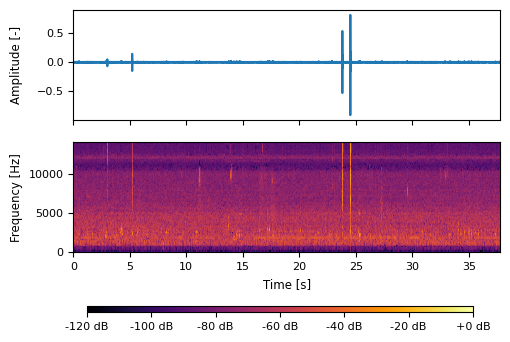

In [9]:
# plot the wave and mel-spectrogram of an audio file from the selected dataset

file_id_num = 0 ## selected file ID number

## in case the file_id_num is in the dataset, plot the wave and mel-spectrogram
if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num]) ## full path to the selected audio file
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

## 2. Automated labeling - find click peaks in the wave files
Note: This works only for files where click peak can be easily detected, i.e. no other noise with higher amplitude is present in the wavefrom

In [10]:
# calculating peak times for each audio file in the selected dataset based on the maximum absolute value of the signal amplitude

# calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref):
    signals = [] # audio wave forms
    signal_times = [] # time stamps in seconds for all samples in an audio file 
    peak_times_1 = [] # in seconds, time of largerst peak in each signal
    peak_times_2 = [] # in seconds, time of 2nd largest peak in each signal
    spectrograms = []

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
        signals.append(signal)
        signal_times.append(time)
        spectrograms.append(D_mel_dB)

        # search abs max value of the signal within the search interval

        search_interval_min = 0 # search from the start of the audio signals
        search_interval_min_index = search_interval_min * sampling_rate
        search_interval_max_index = len(signal)

        j = search_interval_min_index
        peak_index_1 = j
        while j < search_interval_max_index-1:
            if signal[j+1] > signal[peak_index_1]:
                peak_index_1 = j+1
            j = j + 1
        
        peak_time_1 = peak_index_1 / sampling_rate
        peak_times_1.append(peak_time_1)

        # search abs max value of the signal within the search interval excluding the epsilon environment of first peak

        eps_interval = 0.1 # in seconds
        eps_interval_index_values = int(eps_interval * sampling_rate) # number of samples excluded from search in + and - direction
        z = search_interval_min_index
        peak_index_2 = z
        while z < search_interval_max_index-1:
            if (z < peak_index_1 - eps_interval_index_values) or (z > peak_index_1 + eps_interval_index_values):
                if signal[z+1] > signal[peak_index_2]:
                    peak_index_2 = z+1
            z = z + 1

        peak_time_2 = peak_index_2 / sampling_rate
        peak_times_2.append(peak_time_2)


    return signals, signal_times, peak_times_1, peak_times_2, spectrograms 

# get the signals, signal times and peak times for the selected dataset
signals, signal_times, peak_times_1, peak_times_2, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, hop_length, n_mels, dB_ref)

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


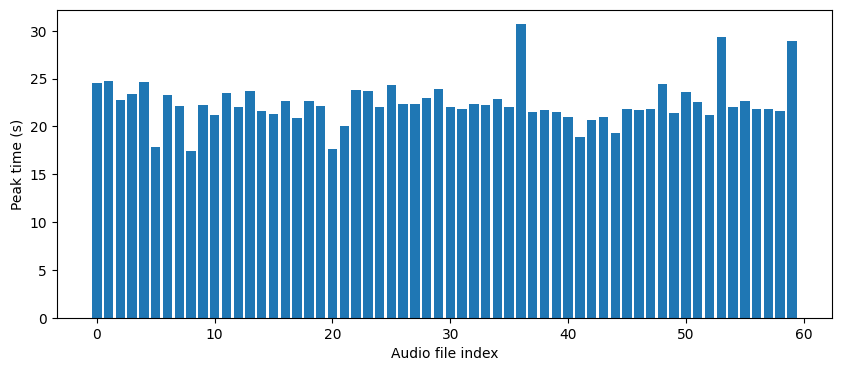

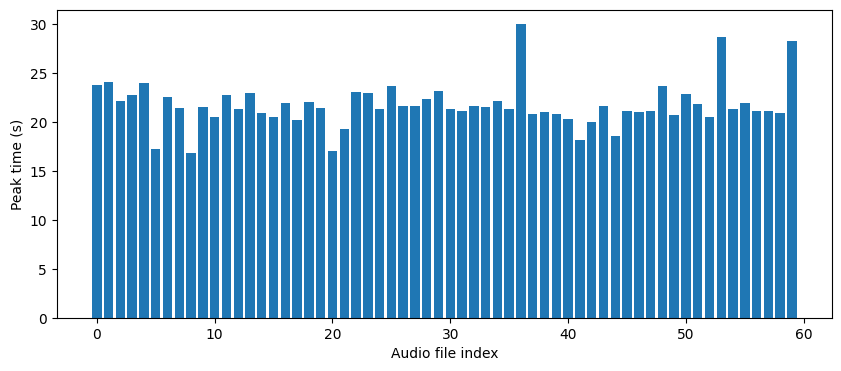

Mean of the peak times in the peg-in-hole process: 22.403921354166666


In [11]:
# check if the peak time are around the same time for all audio files -> same robotic peg-in-hole event was recorded with nearly the same start and stop times
# outliers should be checked

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_1)), peak_times_1)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

# plot for second peak times

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times_2)), peak_times_2)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')
plt.show()


print(f"Mean of the peak times in the peg-in-hole process: {np.mean(peak_times_1)}")

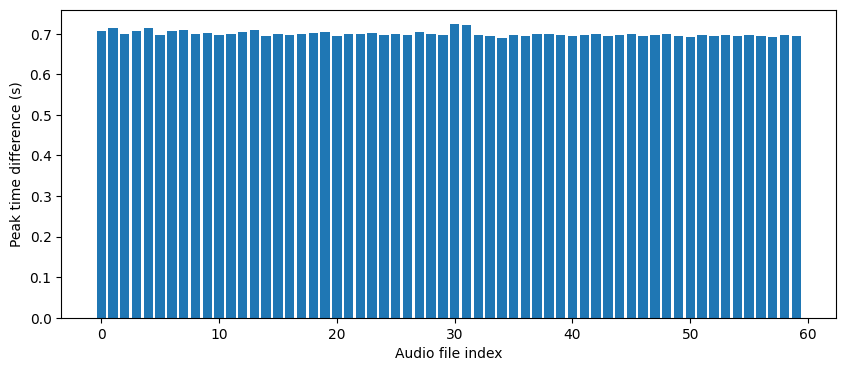

In [12]:
# plot time absolut differences between the peak times of the first and second peak

# changing peak_time_1 and the corresponding peak_time_2 values based on which one occures first
for i in range(len(peak_times_1)):
    if peak_times_1[i] > peak_times_2[i]:
        temp = peak_times_1[i]
        peak_times_1[i] = peak_times_2[i]
        peak_times_2[i] = temp

peak_times_1_arr = np.array(peak_times_1)
peak_times_2_arr = np.array(peak_times_2)

peak_time_diff = peak_times_2_arr - peak_times_1_arr

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_time_diff)), peak_time_diff)
plt.xlabel('Audio file index')
plt.ylabel('Peak time difference (s)')
plt.show()

1.024
24.5156875 23.8093125
0.512


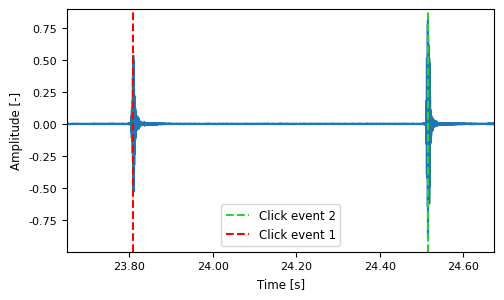

In [33]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

time_interval = (chunk_size/sampling_rate) * 8 # this will be the window size in the real time detection --> 8 chunks with 4096 samples each --> with the 32 kHz sampling rate this is 1.024 seconds
print(time_interval)

signal = signals[file_id_num]
time = signal_times[file_id_num]
peak_time_1 = peak_times_1[file_id_num]
peak_time_2 = peak_times_2[file_id_num]
print(peak_time_1, peak_time_2)

interval = time_interval/2 # for setting the x mina and max limits of the plot --> peak time +/- interval
print(interval)

spectrogramPlotter.plot_signal_interval_with_2_peaks(signal, time, peak_time_1, peak_time_2, interval)

## 3. Go through each audio data with a sliding window and create a labeled training dataset
In the real-time detection, a time frame of 1.024 seconds will be investigated after every new chunk input at 0.128 seconds. 1.024 seconds covers 8 chunks and should contain both click events for the HVA280 connector. The new input chunk is stacked to the most recent input chunk, the oldest chunk rolls out from the invetigated frame at every update.

In [14]:
# duration is set to be larger than the time frame that the two click events covers (around 0.7 seconds)

window_size = sharedValuesConfig.WINDOW_SIZE_LONG ## in this case 64, number of spectrogram columns in the window
## -> corresponds to 1.024 seconds, 8 chunks with 4096 samples each, covers both click events for cerain windows
step_size = sharedValuesConfig.STEP_SIZE ## in this case 8, number of spectrogram columns in the step size
## corresponds 0.128 seconds --> 3/4 overlap
print(window_size, step_size)

64 8


In [39]:
# create spectrogram chunks and corresponding labels for the selected dataset

spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

def createSpectrogramDataset(spectrograms, signals, signal_times, peak_times_1, peak_times_2):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]
        peak_time_1 = peak_times_1[i]
        peak_time_1_index = int(peak_time_1 / resolution)
        peak_time_2 = peak_times_2[i]
        peak_time_2_index = int(peak_time_2 / resolution)

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            if start_idx <= peak_time_1_index < end_idx and start_idx < peak_time_2_index <= end_idx:
                label = 1
            else:
                label = 0

            spec_chunk_dataset.append(spectrogram_chunk)
            spec_chunk_labels.append(label)
            signal_chunks.append(signal_chunk)
            time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times, peak_times_1, peak_times_2)

print(f"chunk dataset length: {len(spec_chunk_dataset)}") # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels
print(f"positive samples: {spec_chunk_labels.count(1)}") # number of chucnks containing click events --> because of the window overlap it is larger than the dataset length
print([i for i, x in enumerate(spec_chunk_labels) if x == 1][:10]) # indices of the chunks containing click events, first 10


chunk dataset length: 16045
16045
positive samples: 161
[184, 185, 186, 474, 475, 476, 746, 747, 1031, 1032]


In [40]:
# Balance the dataset 
## Reduce the number of negative samples to be 10 times the number of positive samples

np.random.seed(42)

def balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks):
    positive_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 1]
    negative_indices = [i for i, x in enumerate(spec_chunk_labels) if x == 0]
    negative_indices_to_keep = np.random.choice(negative_indices, len(positive_indices)*10, replace=False)
    indices_to_keep = np.concatenate((positive_indices, negative_indices_to_keep))
    balanced_spec_chunk_dataset = [spec_chunk_dataset[i] for i in indices_to_keep]
    balanced_spec_chunk_labels = [spec_chunk_labels[i] for i in indices_to_keep]
    balanced_signal_chunks = [signal_chunks[i] for i in indices_to_keep]
    balanced_time_chunks = [time_chunks[i] for i in indices_to_keep]

    return balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks

balanced_spec_chunk_dataset, balanced_spec_chunk_labels, balanced_signal_chunks, balanced_time_chunks = balanceDataset(spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks)

print(f"balanced chunk dataset length: {len(balanced_spec_chunk_dataset)}") # number of spectrogram chunks
print(len(balanced_spec_chunk_labels)) # number of labels
print(f"positive samples: {balanced_spec_chunk_labels.count(1)}") # number of chucnks containing click events --> because of the window overlap it is larger than the dataset length
print([i for i, x in enumerate(balanced_spec_chunk_labels) if x == 1][:10]) # indices of the chunks containing click events, first 10


print(np.min(balanced_spec_chunk_dataset))
print(np.max(balanced_spec_chunk_dataset))

balanced chunk dataset length: 1771
1771
positive samples: 161
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-120.0
-6.593052


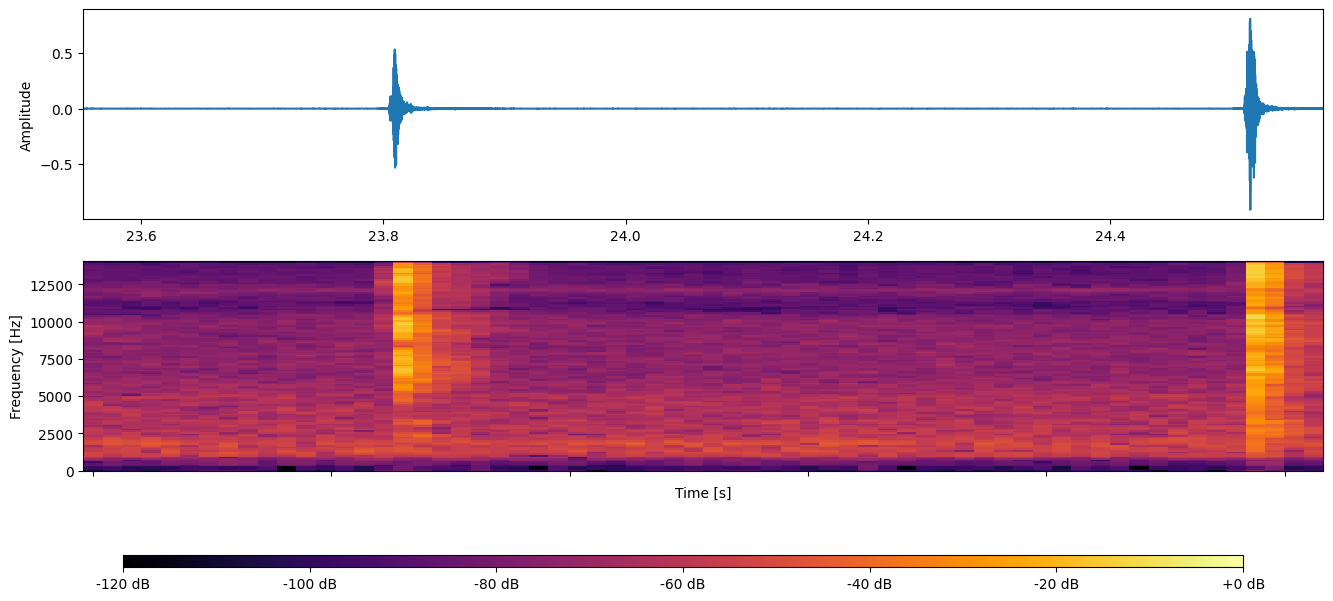

In [45]:
# plot one positive sample from the dataset

chunk_id_to_plot = 0

spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], balanced_spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)

## 4. Save the labeled dataset to the same folder as the audio files processed in .npz format

In [46]:
# save the spectrogram dataset and labels in .npz format into the same directory as the audio files

save_directory = audio_dataset_dir
filename = "hva280_dataset.npz"
file_fullpath = os.path.join(save_directory, filename)

balanced_spec_chunk_dataset_arr = np.array(balanced_spec_chunk_dataset)
balanced_spec_chunk_labels_arr = np.array(balanced_spec_chunk_labels)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=balanced_spec_chunk_dataset_arr, labels=balanced_spec_chunk_labels_arr)

(128, 64)
1771
1771
161


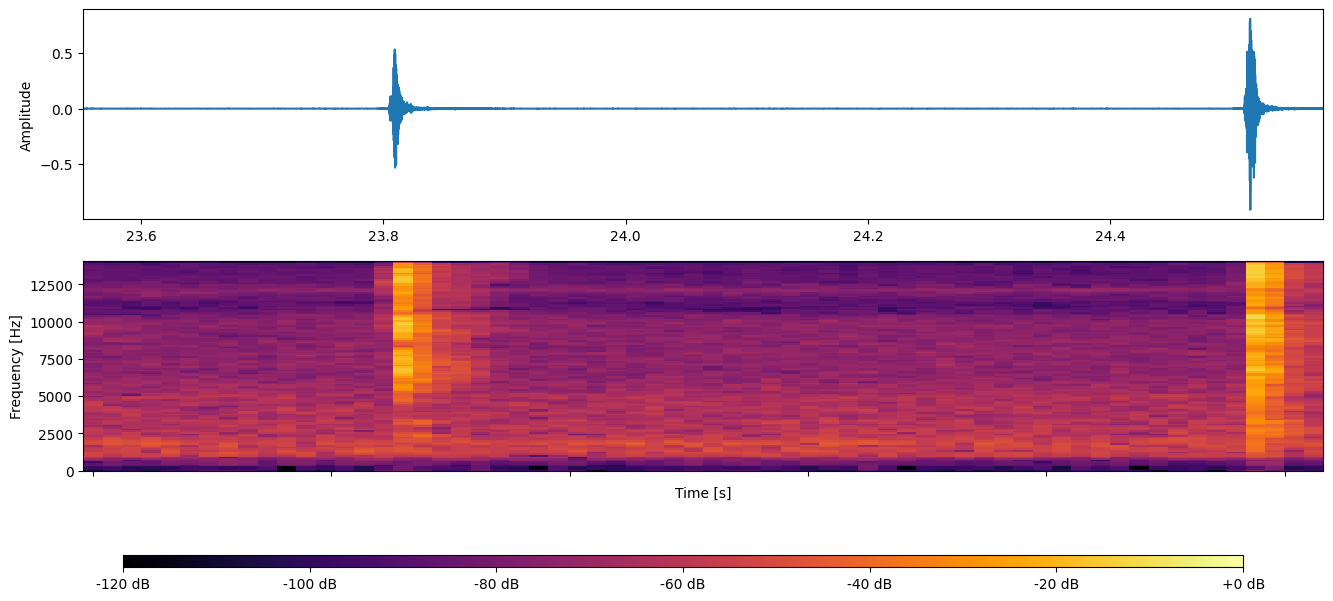

In [47]:
# check if the saved dataset can be loaded

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))
# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# plot out one spectrogram chunk
spectrogramPlotter.plot_single_wave_and_mel_spectrogram(balanced_signal_chunks[chunk_id_to_plot], balanced_time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)